In [8]:
import warnings
warnings.filterwarnings('ignore')
import flowermd
import hoomd
import gsd
import matplotlib.pyplot as plt
import numpy as np
import gsd.hoomd
from flowermd.base import Pack, Simulation
from flowermd.library import KremerGrestBeadSpring, LJChain
from flowermd.utils import get_target_box_number_density
from flowermd.base import Molecule
from flowermd.library import Graphene
from flowermd.library.forcefields import BeadSpring
from flowermd.base.forcefield import BaseHOOMDForcefield
import unyt as u
import hoomd
import mbuild as mb
import numpy as np
from cmeutils.visualize import FresnelGSD
cpu = hoomd.device.CPU()

In [9]:
import mbuild as mb
from mbuild.compound import Compound
from mbuild.lattice import Lattice

from flowermd.base import Molecule, System
class Graphene(System):
    def __init__(
        self,
        x_repeat,
        y_repeat,
        n_layers,
        base_units=dict(),
        periodicity=(True, True, False),
    ):
        # creates an empty 'Compound' object to hold the graphene sheet with 'periodicity' defining whether the structure repeats in x,y,z
        surface = mb.Compound(periodicity=periodicity)
        scale = 1.732021616 # 1.0 for testing, 0.246 for graphene bond lengths
        spacings = [s * scale for s in [1.0, 1.0, 1.0]] # lattice spacing
        points = [[0, 0, 0], [2/3, 1/3, 0]] # unit cell points
        lattice = Lattice(
            lattice_spacing=spacings,
            angles=[90, 90, 120],
            lattice_points={"A": points},
        ) # angles between lattice vectors, 90-90-120 define a 2D hexagonal lattice extended into 3D.
        carbon = Compound(name="C", element="C") # defines a carbon atom that will be used to populate lattice points
        layers = lattice.populate(
            compound_dict={"A": carbon}, x=x_repeat, y=y_repeat, z=n_layers
        ) # populates the lattice using the previously defined carbon atom for every "A" site, repeated in all x,y, and z directions
        surface.add(layers) # adds populated carbon lattice layers to the 'surface' compound, which represents our graphene structure 
        surface.freud_generate_bonds("C", "C", dmin=0.3*scale, dmax=0.6*scale) # generates bonds depending on input distance range, scales with lattice
        surface_mol = Molecule(num_mols=1, compound=surface) # wraps into a Molecule object, creating "1" instance of this molecule

        super(Graphene, self).__init__(
            molecules=[surface_mol],
            base_units=base_units,
        )

    def _build_system(self):
        return self.all_molecules[0]

In [10]:
#OK, so we want to initialize a system with some chains and some flakes
kg_chain = LJChain(lengths=10,num_mols=250)
sheet = Graphene(x_repeat=5, y_repeat=5, n_layers=1, periodicity=(False, False, False))
system = Pack(molecules=[Molecule(compound=sheet.all_molecules[0], num_mols=10), kg_chain], density=0.2, packing_expand_factor = 5)

In [11]:
system.visualize()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [12]:
# this FF is for research question
ff = BeadSpring(
    r_cut=2**(1/6),  # WCA cutoff (purely repulsive)
    beads={
        "A": dict(epsilon=1.0, sigma=1.0),  # chains
        "C": dict(epsilon=1.0, sigma=1.0),  # flakes
    },
    bonds={
        "C-C": dict(r0=1.0, k=500),
        "A-A": dict(r0=1.0, k=500.0),  # increased k to avoid chain collapse
    },
    angles={
        "A-A-A": dict(t0=np.pi, k=10.0),   # moderate stiffness for chains
        "C-C-C": dict(t0=2 * np.pi / 3., k=500),
    },
    dihedrals={
        "A-A-A-A": dict(phi0=0.0, k=1.0, d=-1, n=1),
        "C-C-C-C": dict(phi0=0.1, k=0.1, d=-1, n=1),
    }
)

In [13]:
sim = Simulation(initial_state=system.hoomd_snapshot, forcefield=ff.hoomd_forces, device=cpu, dt = 0.00001, gsd_write_freq=int(1000), log_file_name = "ej_flakes.txt")
sim.run_NVT(n_steps=2000, kT=5, tau_kt=0.1)
sim.flush_writers()
sim.run_NVT(n_steps=5e5,kT=7, tau_kt = 0.00001*10000) #short for initial testing
sim.flush_writers()

Initializing simulation state from a gsd.hoomd.Frame.
Step 1000 of 2000; TPS: 2393.46; ETA: 0.0 minutes
Step 0 of 500000; TPS: 0.0; ETA: nan hours, nan minutes
Step 1000 of 500000; TPS: 3057.85; ETA: 2.7 minutes
Step 2000 of 500000; TPS: 3096.91; ETA: 2.7 minutes
Step 3000 of 500000; TPS: 3113.85; ETA: 2.7 minutes
Step 4000 of 500000; TPS: 3122.19; ETA: 2.6 minutes
Step 5000 of 500000; TPS: 3127.41; ETA: 2.6 minutes
Step 6000 of 500000; TPS: 3126.06; ETA: 2.6 minutes
Step 7000 of 500000; TPS: 3130.18; ETA: 2.6 minutes
Step 8000 of 500000; TPS: 3132.48; ETA: 2.6 minutes
Step 9000 of 500000; TPS: 3133.74; ETA: 2.6 minutes
Step 10000 of 500000; TPS: 3135.06; ETA: 2.6 minutes
Step 11000 of 500000; TPS: 3137.52; ETA: 2.6 minutes
Step 12000 of 500000; TPS: 3139.13; ETA: 2.6 minutes
Step 13000 of 500000; TPS: 3140.4; ETA: 2.6 minutes
Step 14000 of 500000; TPS: 3142.81; ETA: 2.6 minutes
Step 15000 of 500000; TPS: 3144.75; ETA: 2.6 minutes
Step 16000 of 500000; TPS: 3146.0; ETA: 2.6 minutes
Ste

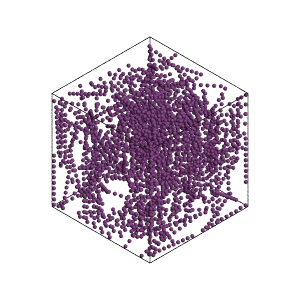

In [14]:
sim_visualizer = FresnelGSD(gsd_file="trajectory.gsd", frame=2, view_axis=(1, 1, 1))
sim_visualizer.view()
# dt of .0001 is as big as we can get with the current parameterization
#Issues:
# Graphene flakes are initialized way too small, or the bond lengths are wrong
# Need to double-check all the bonds, angle, dihedral parameters
# then need to go back and get some chain lengths and flake sizes right.

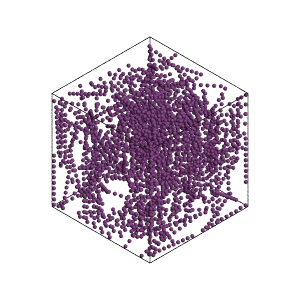

In [15]:
sim_visualizer = FresnelGSD(gsd_file="trajectory.gsd", frame=3, view_axis=(1, 1, 1))
sim_visualizer.view()